In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.interpolate as interp
import scipy.integrate as integ
import pandas as pd

%matplotlib inline

In [3]:
# we load motor data from a text file
j450 = np.loadtxt("J450.txt")

# By interploating it we are basically saying that if we want the thrust at a time we don't
# have data for, draw a line between the point before and the point after using in this example
# y=mx+b and evaluate that function at the time we want
j450interp = sp.interpolate.interp1d(j450[::,0], j450[::,1])

# this is a model of our motor thrust as a function od time
def j450_model(t):
    # If we ask for a time before or after the range we assume thrust is zero
    if t > np.max(j450[::,0]) or t < np.min(j450[::,0]):
        return 0
    # Otherwise we use the interpolate function
    return j450interp(t)


In [4]:
# We're going to assume the mass of the motor decreases linearly from the beginning to the end of the burn
# Here we are basically doing interpolation ourselves (this is all Kg)

def j450_mass(t):
    MASS_INIT = 1223 / 1000
    MASS_FINAL = (1223 - 510) / 1000
    BURN_TIME = 2.3
    if t < 0:
        return MASS_INIT
    if t > BURN_TIME:
        return MASS_FINAL
    # y = mx + b
    return ((MASS_FINAL - MASS_INIT)/BURN_TIME)*t + MASS_INIT

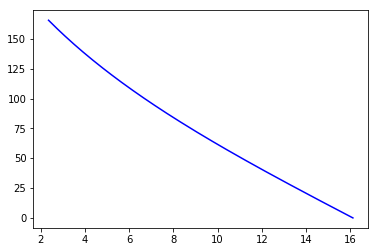

In [43]:
sim = pd.read_csv("subarktos_sim.csv", comment='#')

times = np.array(sim['Time (s)'])
t_burnout = 2.3597 # read this off csv
t_apogee = 16.16 # read this off csv
n_burnout = np.where(times == t_burnout)[0][0]
n_apogee = np.where(times == t_apogee)[0][0]
times = times[n_burnout:n_apogee]
velocities = np.array(sim['Vertical velocity (ft/s)'])[n_burnout:n_apogee]
accels = np.array(sim['Vertical acceleration (ft/s^2)'])[n_burnout:n_apogee]

#build an interpolation function and plot it
velocity_interp = lambda t: velocities[0] if t < t_burnout else (velocities[-1] if t > t_apogee else sp.interpolate.interp1d(times, velocities)(t))
velocity_interp_metric = lambda t: velocity_interp(t)/3.28
plt.plot(times, np.vectorize(velocity_interp_metric)(times), "b-")

In [50]:
# We're gonna use a = fnet/m and drag = B1*v + B2v*v

def acceleration_model(t,B2):
    # If we haven't launched we're sitting on the pad and are gonna read an acceleration of 9.8m/s/s
    if t <= 0:
        return 9.8
    # Get total mass
    m = 4.42 + j450_mass(t)
    #compute Fnet
    B1 = 0
    fnet = (j450_model(t) - 9.8*m - B1*velocity_interp(t) - B2*velocity_interp_metric(t)**2)
    return fnet / m

[0.01264409]


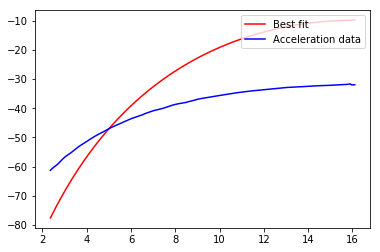

In [51]:
# Make our initial guess on B2
par0 = [1]
# Do a linear least squares fit on our data to try to get more accurate params
par, cov = sp.optimize.curve_fit(np.vectorize(acceleration_model), times, accels, par0)

# Print out our parameters
print(par)

# Graph measured acceleration and our model on top of one another
plt.plot(times, np.vectorize(acceleration_model)(times, *par), "r-", label="Best fit")
plt.plot(times, accels, "b-",label="Acceleration data")
plt.legend(loc='upper right')